# 第5回講義 宿題

## 課題

今Lessonで学んだことに工夫を加えて，CNNでより高精度なCIFAR10の分類器を実装してみましょう．

### 目標値

Accuracy 76%

### ルール


- 訓練データは`x_train`， `t_train`，テストデータは`x_test`で与えられます．
- 予測ラベルは one_hot表現ではなく0~9のクラスラベル で表してください．
- **下のセルで指定されている`x_train`，`t_train`以外の学習データは使わないでください．**
- Pytorchを利用して構いません．
- 今回から基本的にAPI制限はありません．
- ただしCNNベースでないモデル（Vision Transformerなど）やtorchvision等の既存モデル，学習済みモデルは用いないでください．

### 提出方法

- 2つのファイルを提出していただきます．
    1. テストデータ (`x_test`) に対する予測ラベルを`submission_pred.csv`として保存し，**Omnicampusの宿題タブから「第5回 畳み込みニューラルネットワーク」を選択して**提出してください．
    2. それに対応するpythonのコードを`submission_code.py`として保存し，**Omnicampusの宿題タブから「第5回 畳み込みニューラルネットワーク (code)」を選択して**提出してください．pythonファイル自体の提出ではなく，「提出内容」の部分にコードをコピー&ペーストしてください．
      
- なお，採点は1で行い，2はコードの確認用として利用します（成績優秀者はコード内容を公開させていただくかもしれません）．コードの内容を変更した場合は，**1と2の両方を提出し直してください**．

### 評価方法

- 予測ラベルの`t_test`に対する精度 (Accuracy) で評価します．
- 即時採点しLeader Boardを更新します（採点スケジュールは別アナウンス）．
- 締切時の点数を最終的な評価とします．

In [10]:
#import wandb

In [3]:
# ドライブのマウント
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


# submission preparationsubmission = pd.read_csv("/kaggle/input/titanic/submission_pred_v1_lr0.005_nlayer3.csv")

### データの読み込み（この部分は修正しないでください）

In [1]:
import random

import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

#学習データ
x_train = np.load('/kaggle/input/dl5-homework/x_train.npy')
t_train = np.load('/kaggle/input/dl5-homework/t_train.npy')
#テストデータ
x_test = np.load('/kaggle/input/dl5-homework/x_test.npy')

class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        data = x_train.astype('float32')
        self.x_train = []
        for i in range(data.shape[0]):
            self.x_train.append(Image.fromarray(np.uint8(data[i])))
        self.t_train = t_train
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), torch.tensor(t_train[idx], dtype=torch.long)

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        data = x_test.astype('float32')
        self.x_test = []
        for i in range(data.shape[0]):
            self.x_test.append(Image.fromarray(np.uint8(data[i])))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_test)

    def __getitem__(self, idx):
        return self.transform(self.x_test[idx])

trainval_data = train_dataset(x_train, t_train)
test_data = test_dataset(x_test)

### 畳み込みニューラルネットワーク(CNN)の実装

In [2]:
def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)


class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        self.E, self.V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.E = torch.max(self.E, torch.zeros_like(self.E)) # 誤差の影響で負になるのを防ぐ
        self.ZCA_matrix = torch.mm(torch.mm(self.V, torch.diag((self.E.squeeze()+self.epsilon)**(-0.5))), self.V.t())
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x


# (datasetのクラスを自作したので，このあたりの処理が少し変わっています)

zca = ZCAWhitening()
zca.fit(trainval_data)

val_size = 3000
train_data, val_data = torch.utils.data.random_split(trainval_data, [len(trainval_data)-val_size, val_size])  # 訓練データと検証データに分割


# 前処理を定義
transform_train = transforms.Compose([transforms.ToTensor(),
                                      zca])

transform = transforms.Compose([transforms.ToTensor(),
                               zca])

# データセットに前処理を設定
trainval_data.transform = transform_train
test_data.transform = transform

batch_size = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)


0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [22]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

rng = np.random.RandomState(1234)
random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


conv_net = nn.Sequential(
    nn.Conv2d(3, 32, 3),              # 32x32x3 -> 30x30x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 30x30x32 -> 15x15x32

    nn.Conv2d(32, 64, 3),             # 15x15x32 -> 13x13x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.AvgPool2d(2),                  # 13x13x64 -> 6x6x64

    nn.Conv2d(64, 128, 3),            # 6x6x64 -> 4x4x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.AvgPool2d(2),                  # 4x4x128 -> 2x2x128

    nn.Conv2d(128, 256, 2),           # 2x2x128 -> 1x1x256
    nn.BatchNorm2d(256),
    nn.ReLU(),
    
    nn.Conv2d(256, 512, 1),           # 2x2x128 -> 1x1x256
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    nn.Conv2d(512, 1024, 1),           # 2x2x128 -> 1x1x256
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.Conv2d(1024, 2048, 1),           # 2x2x128 -> 1x1x256
    nn.BatchNorm2d(2048),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Dropout(0.5), # Stronger dropout for fully connected layers, where overfitting is more likely to happen
    nn.Linear(2048, 10)
)


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net.apply(init_weights)

n_epochs = 15
lr = 0.005
device = 'cuda'

#wandb.init(project="HW5-v1_layers3", config={
    #"epochs": n_epochs,
    #"batch_size": batch_size,
    #"learning_rate": lr,
    #"optimizer": "Adam",
    #"architecture": "CustomCNN"
#})



conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr = lr, weight_decay = 1e-5)
loss_function = nn.CrossEntropyLoss()

In [23]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = conv_net.forward(x)

        loss = loss_function(y, t)

        loss.backward()

        optimizer.step()

        pred = y.argmax(1)

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)
        t = t.to(device)

        y = conv_net.forward(x)

        loss = loss_function(y, t)

        pred = y.argmax(1)

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))
   # wandb.log({
    #"epoch": epoch,
    #"train_loss": np.mean(losses_train),
    #"train_accuracy": acc_train / n_train,
    #"val_loss": np.mean(losses_valid),
    #"val_accuracy": acc_val / n_val
#})


EPOCH: 0, Train [Loss: 2.420, Accuracy: 0.165], Valid [Loss: 1.776, Accuracy: 0.282]
EPOCH: 1, Train [Loss: 1.732, Accuracy: 0.338], Valid [Loss: 1.435, Accuracy: 0.473]
EPOCH: 2, Train [Loss: 1.381, Accuracy: 0.523], Valid [Loss: 1.260, Accuracy: 0.591]
EPOCH: 3, Train [Loss: 1.146, Accuracy: 0.615], Valid [Loss: 0.928, Accuracy: 0.688]
EPOCH: 4, Train [Loss: 0.994, Accuracy: 0.667], Valid [Loss: 0.873, Accuracy: 0.704]
EPOCH: 5, Train [Loss: 0.918, Accuracy: 0.695], Valid [Loss: 0.920, Accuracy: 0.693]
EPOCH: 6, Train [Loss: 0.852, Accuracy: 0.717], Valid [Loss: 0.761, Accuracy: 0.732]
EPOCH: 7, Train [Loss: 0.800, Accuracy: 0.736], Valid [Loss: 0.670, Accuracy: 0.765]
EPOCH: 8, Train [Loss: 0.760, Accuracy: 0.749], Valid [Loss: 0.750, Accuracy: 0.756]
EPOCH: 9, Train [Loss: 0.729, Accuracy: 0.759], Valid [Loss: 0.663, Accuracy: 0.777]
EPOCH: 10, Train [Loss: 0.699, Accuracy: 0.770], Valid [Loss: 0.654, Accuracy: 0.764]
EPOCH: 11, Train [Loss: 0.666, Accuracy: 0.781], Valid [Loss: 0.

In [24]:
conv_net.eval()

t_pred = []
for x in dataloader_test:

    x = x.to(device)

    # 順伝播
    y = conv_net.forward(x)

    # モデルの出力を予測値のスカラーに変換
    pred = y.argmax(1).tolist()

    t_pred.extend(pred)

submission = pd.Series(t_pred, name='label')

submission.to_csv("submission_pred_v2_normalized.csv", index=False)


In [23]:
import os
os.listdir()

['.virtual_documents', 'submission_pred_v1_lr0.005_layer3.csv']

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions and true labels from validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for x, t in dataloader_valid:
        x = x.to(device)
        t = t.to(device)
        y = conv_net(x)
        preds = y.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(t.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# Plot and log confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.close()


In [ ]:
misclassified_images = []

with torch.no_grad():
    for x, t in dataloader_valid:
        x = x.to(device)
        t = t.to(device)
        y = conv_net(x)
        preds = y.argmax(1)
        for i in range(len(preds)):
            if preds[i] != t[i]:
                img = x[i].cpu()
                true_label = t[i].item()
                pred_label = preds[i].item()
                misclassified_images.append(wandb.Image(img, caption=f"True: {true_label}, Pred: {pred_label}"))
        if len(misclassified_images) >= 20:
            break

wandb.log({"misclassified_images": misclassified_images})


In [ ]:
wandb.finish()


# Try different learning rate
### Starting with the setting of the model!

In [ ]:
def train_model(lr, n_epochs=5):
    wandb.init(project="HW5-v1_change_lr", config={
        "epochs": n_epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "optimizer": "Adam",
        "architecture": "CustomCNN"
    }, name=f"lr_{lr}", group="learning_rate_comparison")

    conv_net = nn.Sequential(
        nn.Conv2d(3, 32, 3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Conv2d(32, 64, 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Conv2d(64, 128, 3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Flatten(),
        nn.Linear(2*2*128, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

    conv_net.apply(init_weights)
    conv_net.to(device)

    optimizer = optim.Adam(conv_net.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        conv_net.train()
        acc_train = 0
        losses_train = []
        n_train = 0
        for x, t in dataloader_train:
            x, t = x.to(device), t.to(device)
            optimizer.zero_grad()
            y = conv_net(x)
            loss = loss_function(y, t)
            loss.backward()
            optimizer.step()
            pred = y.argmax(1)
            acc_train += (pred == t).float().sum().item()
            losses_train.append(loss.item())
            n_train += t.size(0)

        conv_net.eval()
        acc_val = 0
        losses_valid = []
        n_val = 0
        with torch.no_grad():
            for x, t in dataloader_valid:
                x, t = x.to(device), t.to(device)
                y = conv_net(x)
                loss = loss_function(y, t)
                pred = y.argmax(1)
                acc_val += (pred == t).float().sum().item()
                losses_valid.append(loss.item())
                n_val += t.size(0)

        wandb.log({
            "epoch": epoch,
            "train_loss": np.mean(losses_train),
            "train_accuracy": acc_train / n_train,
            "val_loss": np.mean(losses_valid),
            "val_accuracy": acc_val / n_val
        })

    wandb.finish()


In [ ]:
for lr in [0.001, 0.005, 0.01, 0.05]:
    train_model(lr=lr, n_epochs=5)


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▆███
val_loss,█▂▁▁▁
epoch,4
train_accuracy,0.81917
train_loss,0.51781
val_accuracy,0.745
val_loss,0.75149


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▇▆██
val_loss,█▂▃▁▂
epoch,4
train_accuracy,0.83421
train_loss,0.47481
val_accuracy,0.761
val_loss,0.73959


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅███
val_loss,█▄▁▁▂
epoch,4
train_accuracy,0.82121
train_loss,0.52119
val_accuracy,0.76533
val_loss,0.74779


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇█▇
val_loss,█▃▁▁▂
epoch,4
train_accuracy,0.60798
train_loss,1.10277
val_accuracy,0.56333
val_loss,1.2717


#### Adding a confusion matrix


Error: You must call wandb.init() before wandb.log()

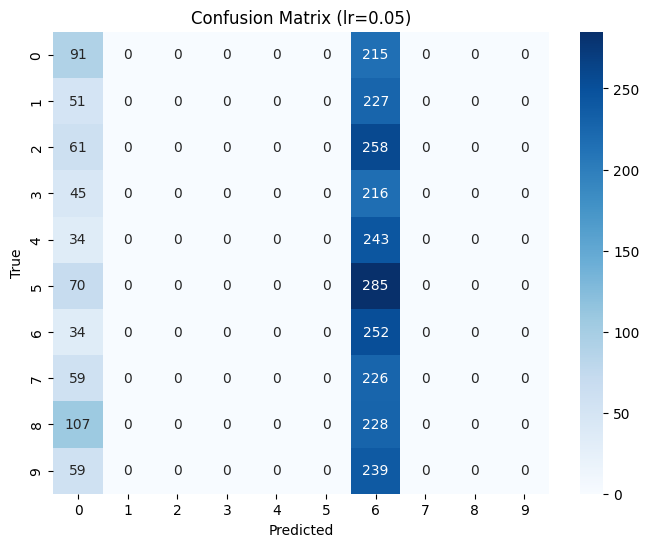

In [ ]:
# After training loop ends in train_model()
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []
conv_net.eval()
with torch.no_grad():
    for x, t in dataloader_valid:
        x, t = x.to(device), t.to(device)
        y = conv_net(x)
        preds = y.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(t.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix (lr={lr})")
plt.xlabel("Predicted")
plt.ylabel("True")
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.close()
